In [1]:
# Required packages and data paths
# Scanpy 1.8
import scanpy as sc
import anndata as ad
import episcanpy.api as epi
import pandas as pd

STUD_PATH = '/mnt/workspace_stud/'
OUTPUT_PATH = f'{STUD_PATH}stud2/output/'
GTF_PATH = f'{STUD_PATH}mbentse/homo_sapiens/homo_sapiens.104.mainChr.gtf'

In [2]:
# define input path and output directories
TISSUE = "liver_sample_9"
INPUT_PATH = f'{OUTPUT_PATH}wp1/{TISSUE}_pp17.h5ad'
output_wp4 = f"{OUTPUT_PATH}wp4/{TISSUE}_obs.csv"
output_wp3 = f"{OUTPUT_PATH}wp3/clusters_{TISSUE}.tsv"
output_sc_csv = f"{OUTPUT_PATH}wp1/scanpy.csv"

In [3]:
# read input file and check matrix size
adata = ad.read(INPUT_PATH)
adata

AnnData object with n_obs × n_vars = 15588 × 958895
    obs: 'nb_features', 'log_nb_features'
    var: 'n_cells', 'commonness', 'prop_shared_cells', 'variability_score'
    layers: 'binary', 'normalised'

In [4]:
# calculate log
epi.pp.log1p(adata)

### Calculate neighbours and clusters

In [5]:
# prepare neighbours for clustering
sc.pp.pca(adata, n_comps=50, svd_solver='arpack', use_highly_variable=False)
sc.pp.neighbors(adata, n_neighbors=25, n_pcs=50, method='umap', metric='euclidean')

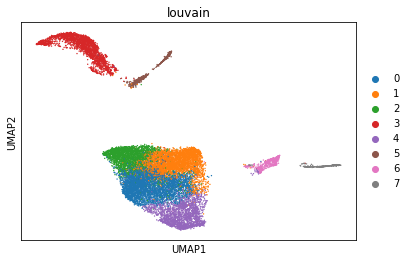

In [6]:
# calculate umap and cluster find clusters with louvain
# Umap: spread = 2.0, min_dist = 0.1
# Louvain: resolution = 0.5 - 0.8
sc.tl.umap(adata, min_dist=0.1, spread=2.0)
epi.tl.louvain(adata, resolution=0.7, use_weights=True)
epi.pl.umap(adata, color=['louvain'])

### Write cluster files

In [7]:
# write files for wp4/3
with open(output_wp4, "w") as obs_file, open(output_wp3, "w") as tsv_file:
    line = "barcode\tcluster\n"
    obs_file.write(line)
    tsv_file.write(line)
    for barcode in range(len(adata.obs.index)):
        line = f"{adata.obs.index[barcode]}\t{adata.obs['louvain'][barcode]}\n"
        obs_file.write(line)
        tsv_file.write(line)

### Write bed files

In [8]:
for cluster in adata.obs['louvain'].unique():
    cluster_adata = adata[adata.obs['louvain'] == cluster]
    epi.pp.filter_features(cluster_adata, min_cells=1)
    cluster_path = f'{OUTPUT_PATH}wp1/{TISSUE}_cluster_{cluster}.bed'
    with open(cluster_path, 'w') as cl_output:
        for peak in cluster_adata.var.index:
            tmp = peak.replace('_', '\t')
            cl_output.write(f"{tmp}\n")

Trying to set attribute `.var` of view, copying.
Trying to set attribute `.var` of view, copying.
Trying to set attribute `.var` of view, copying.
Trying to set attribute `.var` of view, copying.
Trying to set attribute `.var` of view, copying.
Trying to set attribute `.var` of view, copying.
Trying to set attribute `.var` of view, copying.
Trying to set attribute `.var` of view, copying.


### Find features / genes

In [9]:
epi.tl.find_genes(adata,
           gtf_file=GTF_PATH,
           key_added='gene_annotation',
           upstream=10000,
           feature_type='gene',
           annotation='havana',
           raw=False)

adata.var['gene_annotation']

chr1_9955_10355                                       DDX11L1
chr1_29163_29563                           WASH7P;MIR1302-2HG
chr1_267803_268203                                 intergenic
chr1_633354_633754        MTCO3P12;MTCO2P12;MTATP8P1;MTATP6P1
chr1_727023_727423                                 intergenic
                                         ...                 
chrY_56676947_56677347                             unassigned
chrY_56677442_56677842                             unassigned
chrY_56678029_56678429                             unassigned
chrY_56678600_56679000                             unassigned
chrY_56707025_56707425                             unassigned
Name: gene_annotation, Length: 958895, dtype: object

### Filter unassigned / intergenic features

In [10]:
assigned_features = adata.var[adata.var['gene_annotation'] != "intergenic"]
assigned_features = assigned_features[assigned_features['gene_annotation'] != "unassigned"]
assigned_adata = adata[:, assigned_features.index]

assigned_adata

View of AnnData object with n_obs × n_vars = 15588 × 128560
    obs: 'nb_features', 'log_nb_features', 'louvain'
    var: 'n_cells', 'commonness', 'prop_shared_cells', 'variability_score', 'gene_annotation'
    uns: 'log1p', 'pca', 'neighbors', 'umap', 'louvain', 'louvain_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'binary', 'normalised'
    obsp: 'distances', 'connectivities'

### Replace peaks with gene names

In [11]:
names = []

for n in assigned_adata.var['gene_annotation'].values:
    #n = n.split(';')
    #names.append(n[0])
    names.append(n)
    
assigned_adata.var_names = pd.Index(names)

In [12]:
# make new feature names unique and write them into raw
assigned_adata.var_names_make_unique(join="_")
assigned_adata.raw = assigned_adata

### Rank genes

... storing 'gene_annotation' as categorical


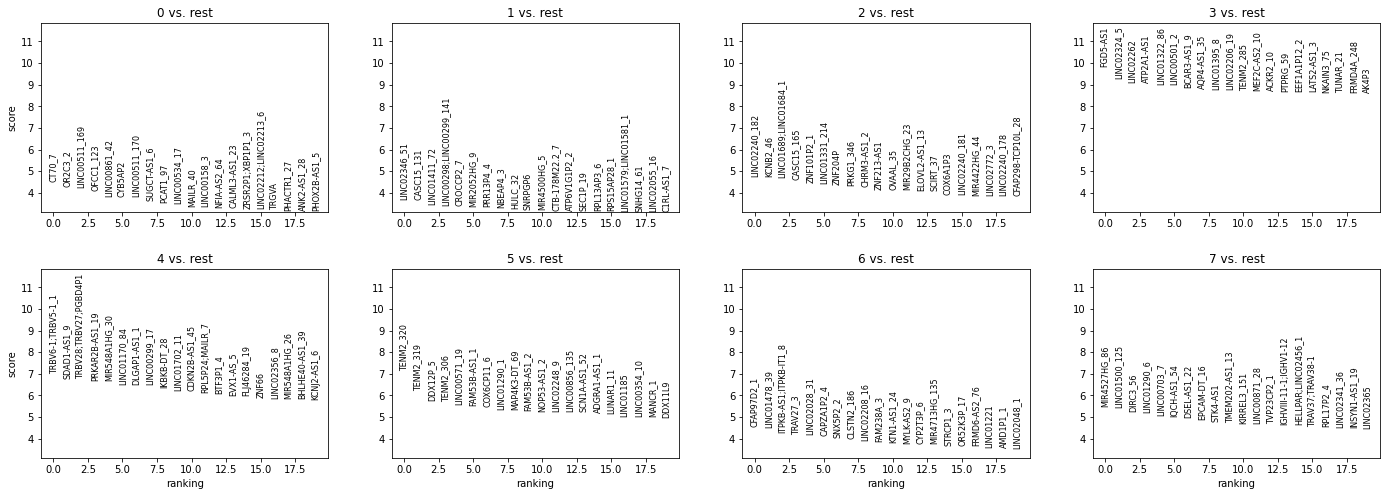

In [13]:
sc.tl.rank_genes_groups(assigned_adata, groupby='louvain', use_raw=False)
#sc.tl.filter_rank_genes_groups(assigned_adata, groupby='louvain', use_raw=False)
sc.pl.rank_genes_groups(assigned_adata)

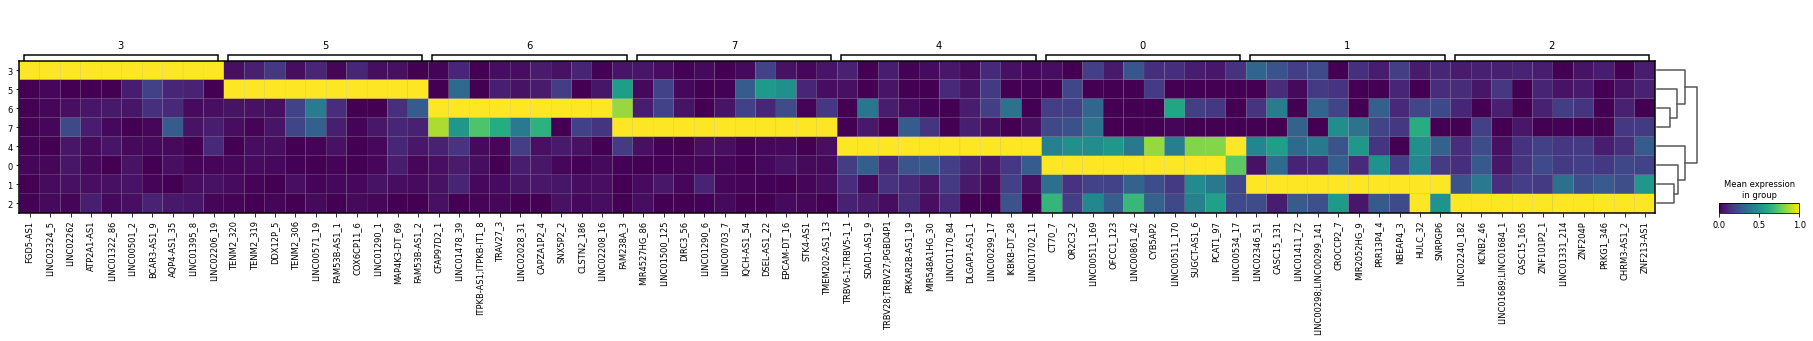

In [14]:
sc.pl.rank_genes_groups_matrixplot(assigned_adata, standard_scale='var', n_genes=10)

## Preparing for celltyp annotation

#### Remove marker gene count (gene_count --> gene) 

In [15]:
result = assigned_adata.uns['rank_genes_groups']
for i, name_list in enumerate(result['names']):
    for j, name_string in enumerate(name_list):
        result['names'][i][j] = name_string.split('_')[0]

pd.DataFrame(result['names'])

,0,1,2,3,4,5,6,7
0,CT70,LINC02346,LINC02240,FGD5-AS1,TRBV6-1;TRBV5-1,TENM2,CFAP97D2,MIR4527HG
1,OR2C3,CASC15,KCNB2,LINC02324,SDAD1-AS1,TENM2,LINC01478,LINC01500
2,LINC00511,LINC01411,LINC01689;LINC01684,LINC02262,TRBV28;TRBV27;PGBD4P1,DDX12P,ITPKB-AS1;ITPKB-IT1,DIRC3
3,OFCC1,LINC00298;LINC00299,CASC15,ATP2A1-AS1,PRKAR2B-AS1,TENM2,TRAV27,LINC01290
4,LINC00861,CROCCP2,ZNF101P2,LINC01322,MIR548A1HG,LINC00571,LINC02028,LINC00703
...,...,...,...,...,...,...,...,...
128555,RPS4XP20,BCAR3-AS1,LINC01060,SLC9A3R1-AS1,LINC01395,SHROOM2P1,KCNB2,FAM96AP2
128556,PWRN4,ALMS1P1,MEF2C-AS2,FABP6-AS1,CCT4P1,PSMD7-DT,LINC01019,LINC02212;LINC02213
128557,NDUFA5P10,AADACP1;AADACL2-AS1,MIR646HG,BBOX1-AS1,CRYZL2P-SEC16B,LINC02686,LINC02015,SYN3-AS1
128558,BCAR3-AS1,AQP4-AS1,RPS24P8,VIPR1-AS1,SETP12,ZMIZ1-AS1,MIR924HG,C8orf44-SGK3


#### Find first 100 unique marker genes per cluster

In [16]:
indices = {}
cutoff = 100

groups = result['names'].dtype.names
for group in groups:
    uniques = []
    indices[group] = []
    for i, value in enumerate(result['names'][group]):
        if value in uniques:
            continue
        uniques.append(value)
        indices[group].append(i)
        if len(uniques) == cutoff:
            break

### Writing to csv for SCSA

In [17]:
groups = result['names'].dtype.names
dat = pd.DataFrame({group + '_' + key[:1]: result[key][group][indices[group]] for group in groups for key in ['names', 'logfoldchanges','scores','pvals']})
dat.to_csv(output_sc_csv)

dat

,0_n,0_l,0_s,0_p,1_n,1_l,1_s,1_p,2_n,2_l,...,5_s,5_p,6_n,6_l,6_s,6_p,7_n,7_l,7_s,7_p
0,CT70,1.570221,4.528503,0.000006,LINC02346,2.303584,3.695925,0.000222,LINC02240,2.347708,...,7.140951,2.745250e-12,CFAP97D2,3.642898,4.554695,0.000007,MIR4527HG,4.743104,5.475344,8.720567e-08
1,OR2C3,1.772832,4.293183,0.000018,CASC15,1.767365,3.667639,0.000248,KCNB2,2.000834,...,5.736476,1.547249e-08,LINC01478,2.994647,4.517507,0.000008,LINC01500,4.646305,5.423344,1.139787e-07
2,LINC00511,1.572855,4.238877,0.000023,LINC01411,2.036067,3.433911,0.000601,LINC01689;LINC01684,3.559038,...,5.562428,4.040760e-08,ITPKB-AS1;ITPKB-IT1,3.987688,4.265851,0.000024,DIRC3,5.013838,5.222586,3.148473e-07
3,OFCC1,2.157424,4.075424,0.000047,LINC00298;LINC00299,2.201156,3.412174,0.000651,CASC15,2.903890,...,5.514434,5.246001e-08,TRAV27,3.536749,4.195615,0.000032,LINC01290,4.818239,5.197279,3.568913e-07
4,LINC00861,1.519671,3.841967,0.000124,CROCCP2,1.371344,3.395232,0.000692,ZNF101P2,2.620773,...,5.460467,7.016446e-08,LINC02028,2.974964,4.162855,0.000037,LINC00703,4.780829,5.063053,6.908850e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,SEZ6L-AS1,1.190115,2.574901,0.010057,ZMIZ1-AS1,1.138339,2.728840,0.006381,SLC25A38P1,1.381271,...,3.879170,1.166139e-04,PCSK6-AS1,3.097452,2.996986,0.002860,HNRNPMP2,3.731807,3.597666,3.705209e-04
96,HNRNPCP8,2.727129,2.572156,0.010141,LINC00929,1.903313,2.722357,0.006509,PCAT1,1.423699,...,3.876197,1.180016e-04,TPTE2P6,3.567611,2.993818,0.002890,CSTP1,4.135988,3.594191,3.754989e-04
97,NKAIN3,2.922876,2.572146,0.010142,SMIM2-AS1,1.637680,2.721774,0.006522,LINC02098,1.713824,...,3.870330,1.208356e-04,SUCLG2-AS1,2.587428,2.992606,0.002899,LINC01416,2.799360,3.588380,3.832732e-04
98,EXTL2P1,1.966295,2.566108,0.010316,SNHG19,1.465843,2.720739,0.006541,LINC01967,2.368494,...,3.866024,1.229624e-04,LINC00523,3.573555,2.991863,0.002909,LINC01491,4.944777,3.583396,3.907926e-04


### Create bash command to execute

In [18]:
python3 = "/home/stud2/.conda/envs/datanew/bin/python3.9"
scsa_loc = f"{STUD_PATH}stud2/SCSA/SCSA.py"
wholeDB_loc = f"{STUD_PATH}stud2/SCSA/whole.db"
input_csv = output_sc_csv
results_file = "result"
output_file = f"{OUTPUT_PATH}wp1/ergebnisse.txt"

scsa_cmd = f"{python3} {scsa_loc} -d {wholeDB_loc} -i {input_csv} -s scanpy -E -f 1.5 -p 0.01 -o {results_file} -m txt"
scsa_cmd += f" > {output_file}; tail {output_file}"
print(scsa_cmd)

/home/stud2/.conda/envs/datanew/bin/python3.9 /mnt/workspace_stud/stud2/SCSA/SCSA.py -d /mnt/workspace_stud/stud2/SCSA/whole.db -i /mnt/workspace_stud/stud2/output/wp1/scanpy.csv -s scanpy -E -f 1.5 -p 0.01 -o result -m txt > /mnt/workspace_stud/stud2/output/wp1/ergebnisse.txt; tail /mnt/workspace_stud/stud2/output/wp1/ergebnisse.txt


In [19]:
!$scsa_cmd


#Cluster Type Celltype Score Times
['0', 'Good', 'Goblet cell', 1.003507186789831, 5.252302277708207]
['1', 'Good', 'Oogenesis phase fetal germ cell', 0.7071067811865476, 1.0]
['2', 'Good', 'SLC16A7+ cell', 1.9134230590351473, 6.8873991541268405]
['3', 'Good', 'Endothelial cell', 0.9541504823045417, 2.0960214502678496]
['4', 'Good', 'FGFR1HighNME5- epithelial cell', 0.5209793360298843, '-']
['5', 'Good', 'Multilymphoid progenitor cell', 0.9552719047555855, 11.353425922964671]
['6', 'Good', 'Oocyte', 1.299787552831751, 6.052267175681159]
['7', 'Good', 'Multilymphoid progenitor cell', 1.1185896915597364, 3.5948303611336203]


In [20]:
pd.read_csv('result', sep='\t')

,Cell Type,Z-score,Cluster
0,Goblet cell,1.003507,0
1,Gonadal endothelial cell,0.191060,0
2,Microglial cell,0.191060,0
3,Oligodendrocyte,-1.385628,0
4,Oogenesis phase fetal germ cell,0.707107,1
5,Multilymphoid progenitor cell,-0.707107,1
6,SLC16A7+ cell,1.913423,2
7,Pyramidal cell,0.277815,2
8,Purkinje cell,0.160670,2
9,Natural killer T (NKT) cell,0.083155,2


In [21]:
s = open('/mnt/workspace_stud/stud2/output/wp1/ergebnisse.txt').read().splitlines()
s

['Version V1.1 [2020/07/03]',
 'DB load: 47347 3 3 48257 37440',
 "Namespace(input='/mnt/workspace_stud/stud2/output/wp1/scanpy.csv', output='result', db='/mnt/workspace_stud/stud2/SCSA/whole.db', source='scanpy', cluster='all', MarkerDB=None, foldchange=1.5, pvalue=0.01, weight=100.0, species='Human', tissue='All', outfmt='txt', celltype='normal', target='cellmarker', Gensymbol=True, norefdb=False, noprint=False, list_tissue=False)",
 'Version V1.1 [2020/07/03]',
 'DB load: 47347 3 3 48257 37440',
 'load markers: 45409',
 '############################## Cluster 0 ##############################',
 '',
 'Cell Num: 4',
 'Gene Num: 3',
 'Not Zero: 4',
 'Cluster 0 Gene number: 49',
 '------------------------------------------------------------',
 'Type                Cell Type           Score     Times',
 '------------------------------------------------------------',
 'Good               Goblet cell          1.0035    5.3  ',
 '------------------------------------------------------------'